### [ 데이터 전처리 ]<hr>
1. 사용할 컬럼만 추출 및 파일 경량화
2. 파일 타입 확인 및 타입 변경

[1] 컬럼 추출 및 파일 경량화

In [ ]:

import pandas as pd
import numpy as np


## 그래프 작성시 한글깨짐 
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'Malgun Gothic'


# 원본 파일 경로
file_path = "./Data/한국교통안전공단_전기화물차 센서데이터_20230807.csv"
df_origin = pd.read_csv(file_path,encoding='CP949')

# 필요한 컬럼 리스트
cols = [
    '속도', '클러스터_주행거리', '고도',

    # 배터리 팩 전기량(전력 계산/회생 분석)
    '배터리_관리_시스템_고전압_팩_전압',
    '배터리_관리_시스템_고전압_팩_전류',

    # 배터리 온도(셀) 및 냉각수
    '배터리_관리_시스템_온도01','배터리_관리_시스템_온도02','배터리_관리_시스템_온도03',
    '배터리_관리_시스템_온도04','배터리_관리_시스템_온도05',
    '배터리_관리_시스템_배터리_냉각수_입구_온도',

    # 냉각 시스템 작동 신호
    '배터리_관리_시스템_배터리_냉각기_상태',
    '배터리_관리_시스템_전동식워터펌프속도',
    '배터리_관리_시스템_배터리_밸브_모드',
    '배터리_관리_시스템_베터리_밸브_피드백',
    '배터리_관리_시스템_배터리_밸브_요구_사항',
    '배터리_관리_시스템_전력전자_밸브_피드백',
    '배터리_관리_시스템_전력전자_밸브_요구_사항',

    # 회생/제동 관련 보조
    '차량제어기_브레이크_스위치',
    '마이크로컨트롤_유닛_모터_토크_실제',
    '마이크로컨트롤_유닛_모터_속도',

    # 냉난방(에어컨/히터)
    '교류_고전압히터',
    '교류_컴프레서',           # 없으면 아래 압력 컬럼으로 대체 추정
    '교류_컴프레서_압력',
    '교류_외부_온도',
    '교류_내부_온도_전선',
    '교류_덕트_온도_드라이버',
]

df = pd.read_csv(file_path, usecols=cols, encoding='CP949')

## 1이하의 속도는 이상치로 판단
df.loc[df['속도'] < 1.0, '속도'] = np.nan

df = df.dropna(subset=['속도'])

# 새로운 경량 파일로 저장
df.to_csv("EV_sensor_core.csv", index=False, encoding='utf-8')

print("경량 데이터 저장 완료: EV_sensor_core.csv")
print("남은 컬럼 수:", len(df.columns))
print("컬럼 목록:", df.columns.tolist())

df.head()

df.info()
for col in df.columns :
    print(f'{col} --- {df[col].nunique()}개')
    print(df[col].unique())
# df['마이크로컨트롤_유닛_모터_속도'].max()

display(df[['속도', '마이크로컨트롤_유닛_모터_속도']].corr())

경량 데이터 저장 완료: EV_sensor_core.csv
남은 컬럼 수: 27
컬럼 목록: ['속도', '고도', '교류_컴프레서', '교류_컴프레서_압력', '교류_덕트_온도_드라이버', '교류_고전압히터', '교류_내부_온도_전선', '교류_외부_온도', '배터리_관리_시스템_배터리_냉각기_상태', '배터리_관리_시스템_배터리_냉각수_입구_온도', '배터리_관리_시스템_배터리_밸브_모드', '배터리_관리_시스템_베터리_밸브_피드백', '배터리_관리_시스템_배터리_밸브_요구_사항', '배터리_관리_시스템_고전압_팩_전류', '배터리_관리_시스템_고전압_팩_전압', '배터리_관리_시스템_전동식워터펌프속도', '배터리_관리_시스템_전력전자_밸브_피드백', '배터리_관리_시스템_전력전자_밸브_요구_사항', '배터리_관리_시스템_온도01', '배터리_관리_시스템_온도02', '배터리_관리_시스템_온도03', '배터리_관리_시스템_온도04', '배터리_관리_시스템_온도05', '클러스터_주행거리', '마이크로컨트롤_유닛_모터_속도', '마이크로컨트롤_유닛_모터_토크_실제', '차량제어기_브레이크_스위치']
<class 'pandas.core.frame.DataFrame'>
Index: 1628 entries, 166 to 11571
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   속도                        1628 non-null   float64
 1   고도                        1628 non-null   float64
 2   교류_컴프레서                   1628 non-null   int64  
 3   교류_컴프레서_압력                1628 non-null   float

,속도,마이크로컨트롤_유닛_모터_속도
속도,1.000000,0.989884
마이크로컨트롤_유닛_모터_속도,0.989884,1.000000


### 1. 회생제동 발생 비율 분석 <hr>

In [20]:
df_RE = df[['마이크로컨트롤_유닛_모터_속도', '배터리_관리_시스템_고전압_팩_전류']].copy()

# df_RE.info()

df_RE['motor_speed'] = df_RE['마이크로컨트롤_유닛_모터_속도']
df_RE['pack_current'] = df_RE['배터리_관리_시스템_고전압_팩_전류']

# 감속 이벤트 탐지 (속도 감소 구간)
df_RE['decel'] = (df_RE['motor_speed'].diff() < -50).astype(int)  # 임계치 50rpm
# display(df_RE['decel'])

# 회생 구간 탐지 (음수 전류)
df_RE['regen'] = (df_RE['pack_current'] < 0).astype(int)

# 감속 + 회생 동시 구간
df_RE['regen_event'] = ((df_RE['decel'] == 1) & (df_RE['regen'] == 1)).astype(int)

# 회생 커버리지 계산
regen_ratio = df_RE['regen_event'].sum() / df_RE['decel'].sum() * 100
print(f"감속 중 회생제동 발생 비율: {regen_ratio:.2f}%")

# df_RE


감속 중 회생제동 발생 비율: 58.76%


<Axes: title={'center': '감속 중 회생제동 발생 비율'}>

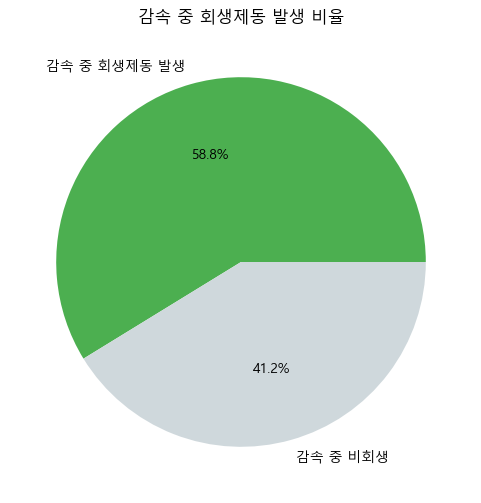

In [3]:
data = pd.Series(
    [58.76, 41.24],
    index=['감속 중 회생제동 발생', '감속 중 비회생']
)

data.plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6, 6),
    colors=['#4CAF50', '#CFD8DC'],
    title='감속 중 회생제동 발생 비율'
)

### [ 2. 브레이크 스위치 ON 비율 vs 회생비율 ]<hr>


In [ ]:

# 필요한 컬럼만 추출
cols = ['차량제어기_브레이크_스위치', '배터리_관리_시스템_고전압_팩_전류', '마이크로컨트롤_유닛_모터_속도']
df_brake = df[cols].copy()

# display(df_brake)

# 회생제동(팩전류 음수)
df_brake['is_regen'] = (df_brake['배터리_관리_시스템_고전압_팩_전류'] < 0).astype(int)

# 비율 계산
brake_on_ratio = df_brake['차량제어기_브레이크_스위치'].mean() * 100
regen_ratio = df_brake['is_regen'].mean() * 100

# 브레이크 ON 시 회생제동 비율
regen_when_brake = df_brake.loc[df_brake['차량제어기_브레이크_스위치'] == 1, 'is_regen'].mean() * 100

display(brake_on_ratio, regen_ratio, regen_when_brake)




np.float64(20.454545454545457)

np.float64(26.044226044226043)

np.float64(49.849849849849846)

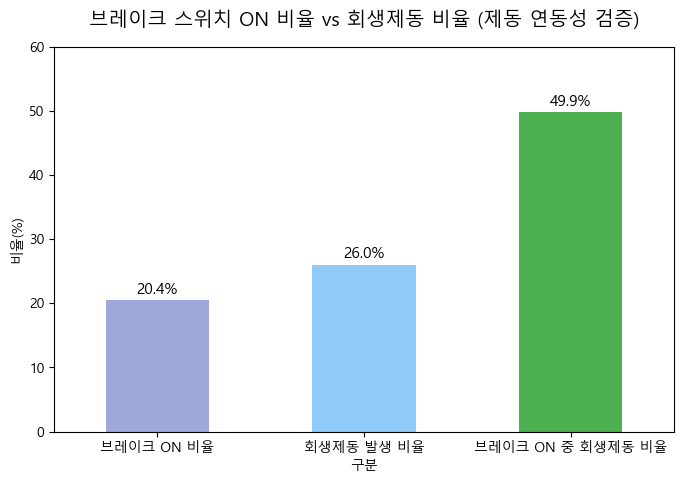

In [18]:
data = pd.DataFrame({
    '구분': ['브레이크 ON 비율', '회생제동 발생 비율', '브레이크 ON 중 회생제동 비율'],
    '비율(%)': [20.45, 26.04, 49.85]
})

# 그래프 그리기
ax = data.plot(kind='bar', x='구분', y='비율(%)', color=['#9FA8DA', '#90CAF9', '#4CAF50'], legend=False, figsize=(8,5))
plt.title('브레이크 스위치 ON 비율 vs 회생제동 비율 (제동 연동성 검증)', fontsize=14, pad=15)
plt.ylabel('비율(%)')
plt.xticks(rotation=0)
plt.ylim(0, 60)

# 막대 위에 수치 표시
for i, v in enumerate(data['비율(%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)
    
plt.show()

## [구간 속도별 회생제동 분포]

'여기'

,속도,배터리_전류,배터리_전압,순간_전력_kW,속도_구간
9875,80.191599,-9.8,366.9,-3.59562,80+
9876,80.154558,-33.8,367.3,-12.41474,80+
9877,80.154558,-30.1,367.9,-11.07379,80+
9880,79.302639,-4.3,367.1,-1.57853,60~80
9887,79.117442,11.9,366.9,4.36611,60~80



회생 제동 분석
회생 제동 발생 횟수: 360
평균 속도: 42.19 rpm
평균 회생 전류: -25.15 A
평균 회생 전력: -9.29 kW
최대 회생 전류: -99.60 A
총 회생 에너지: -0.93 kWh

속도 구간별 회생 제동 통계 (A)
       count       mean   min
속도_구간                        
0~20      53  -9.086792 -29.5
20~40    103 -23.730097 -59.3
40~60    147 -29.234694 -99.6
60~80     54 -32.522222 -57.3
80+        3 -24.566667 -33.8


C:\Users\kdt008\AppData\Local\Temp\ipykernel_14900\2387337358.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regen_by_speed = regen_data.groupby('속도_구간')['배터리_전류'].agg(['count', 'mean', 'min'])


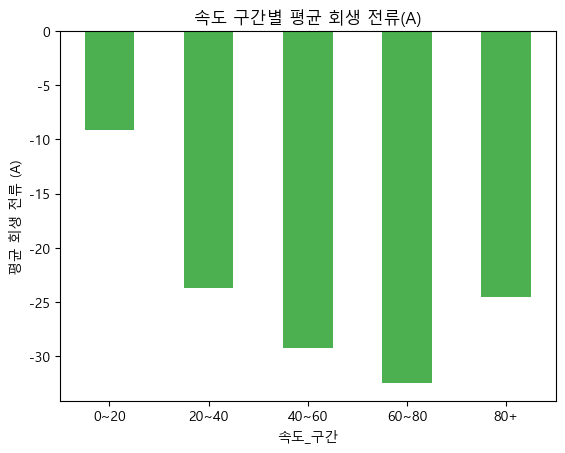

In [ ]:


# 1️⃣ 데이터 준비
cols = [
    '속도',   
    '배터리_관리_시스템_고전압_팩_전류',
    '배터리_관리_시스템_고전압_팩_전압'
]
df_regen = df[cols].copy()

# 컬럼명 통일
df_regen = df_regen.rename(columns={
    '배터리_관리_시스템_고전압_팩_전류': '배터리_전류',
    '배터리_관리_시스템_고전압_팩_전압': '배터리_전압'
})


# ------------------------------------------------
# 속도 구간화 (rpm 기준)
# ------------------------------------------------
df_regen['속도_구간'] = pd.cut(
    df_regen['속도'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0~20', '20~40', '40~60', '60~80', '80+']
)

# display(df_regen[df_regen['속도'].between()])
display('여기', df_regen.nlargest(5, '속도'))

# ------------------------------------------------
# 5️⃣ 회생 제동 데이터 추출 (전류 음수 기준)
# ------------------------------------------------
regen_data = df_regen[df_regen['배터리_전류'] < -5].copy()

print("\n" + "="*80)
print("회생 제동 분석")
print("="*80)
print(f"회생 제동 발생 횟수: {len(regen_data)}")

if len(regen_data) > 0:
    print(f"평균 속도: {regen_data['속도'].mean():.2f} rpm")
    print(f"평균 회생 전류: {regen_data['배터리_전류'].mean():.2f} A")
    # print(f"평균 회생 전력: {regen_data['순간_전력_kW'].mean():.2f} km/h")
    # print(f"최대 회생 전류: {regen_data['배터리_전류'].min():.2f} A")
    # print(f"총 회생 에너지: {regen_data['순간_전력_kW'].sum()/3600:.2f} kWh")  # 1초 샘플링 가정

    # ------------------------------------------------
    # 6️⃣ 속도 구간별 회생 제동 통계
    # ------------------------------------------------
    regen_by_speed = regen_data.groupby('속도_구간')['배터리_전류'].agg(['count', 'mean', 'min'])
    print("\n속도 구간별 회생 제동 통계 (A)")
    print(regen_by_speed)

    # ------------------------------------------------
    # 7️⃣ 시각화 (옵션)
    # ------------------------------------------------
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    regen_by_speed['mean'].plot(
        kind='bar',
        color='#4CAF50',
        title='속도 구간별 평균 회생 전류(A)',
    )
    plt.ylabel('평균 회생 전류 (A)')
    plt.xticks(rotation=0)
    plt.show()


            평균 전력(kW)  평균 모터 속도(rpm)
slope_zone                          
하강           1.897325    2562.771186
평지          -5.950379     382.672273
상승           6.996623    2503.965986


C:\Users\kdt008\AppData\Local\Temp\ipykernel_14900\705555088.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_slope.groupby('slope_zone').agg({


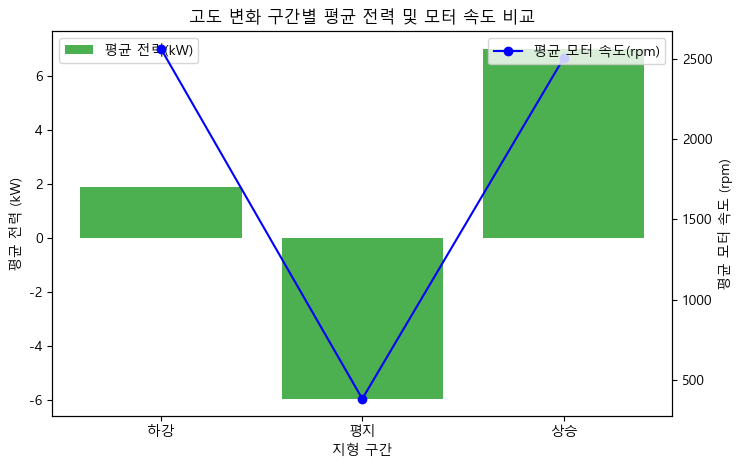

In [7]:
# ----------------------------------------------
#  필요한 컬럼만 추출
# ----------------------------------------------
cols = [
    '고도',
    '배터리_관리_시스템_고전압_팩_전류',
    '배터리_관리_시스템_고전압_팩_전압',
    '마이크로컨트롤_유닛_모터_속도'
]
df_slope = df_origin[cols].copy()

# ----------------------------------------------
# 데이터 타입 처리 및 결측 제거
# ----------------------------------------------
for c in cols:
    df_slope[c] = pd.to_numeric(df_slope[c], errors='coerce')
df_slope = df_slope.dropna()

# ----------------------------------------------
# 고도 변화량 계산 (m 단위)
# ----------------------------------------------
df_slope['alt_diff'] = df_slope['고도'].diff() 

# ----------------------------------------------
# 구간 분류: 상승 / 평지 / 하강
#     ±1m 기준은 노이즈 제거용 (필요시 ±2~3m로 조정 가능)
# ----------------------------------------------
df_slope['slope_zone'] = pd.cut(
    df_slope['alt_diff'],
    bins=[-999, -1, 1, 999],
    labels=['하강', '평지', '상승']
)

# ----------------------------------------------
# 전력 계산 (kW)
# ----------------------------------------------
df_slope['power_kw'] = (
    df_slope['배터리_관리_시스템_고전압_팩_전류'] *
    df_slope['배터리_관리_시스템_고전압_팩_전압']
) / 1000

# ----------------------------------------------
# 구간별 평균 전력(kW) 및 평균 모터 속도(rpm)
# ----------------------------------------------
result = df_slope.groupby('slope_zone').agg({
    'power_kw': 'mean',
    '마이크로컨트롤_유닛_모터_속도': 'mean'
}).rename(columns={'power_kw': '평균 전력(kW)', '마이크로컨트롤_유닛_모터_속도': '평균 모터 속도(rpm)'})

print(result)

# ----------------------------------------------
#  시각화
# ----------------------------------------------
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, ax1 = plt.subplots(figsize=(8,5))

# 막대그래프: 평균 전력
ax1.bar(result.index, result['평균 전력(kW)'], color=['#4CAF50','#4CAF50','#4CAF50'], label='평균 전력(kW)')
ax1.set_ylabel('평균 전력 (kW)')
ax1.set_xlabel('지형 구간')
ax1.legend(loc='upper left')

# 꺾은선 그래프: 평균 모터 속도
ax2 = ax1.twinx()
ax2.plot(result.index, result['평균 모터 속도(rpm)'], color='blue', marker='o', label='평균 모터 속도(rpm)')
ax2.set_ylabel('평균 모터 속도 (rpm)')
ax2.legend(loc='upper right')

plt.title('고도 변화 구간별 평균 전력 및 모터 속도 비교')
plt.xticks(rotation=0)
plt.show()


### [ 에어컨 사용 여부별 효율 비교 ]<hr>
<p> 에어컨 또는 히터 사용 시 전비 감소율은? </p>

In [8]:
df_HC = pd.DataFrame(
    df[['클러스터_주행거리',
        '배터리_관리_시스템_고전압_팩_전류',
        '배터리_관리_시스템_고전압_팩_전압',
        '교류_컴프레서',
        '교류_내부_온도_전선',
        '교류_외부_온도']]
)

# ✅ 2. 결측값 제거 및 숫자형 변환
for c in df_HC.columns:
    df_HC[c] = pd.to_numeric(df_HC[c], errors='coerce')
df_HC = df_HC.dropna(subset=['클러스터_주행거리', '배터리_관리_시스템_고전압_팩_전류', '배터리_관리_시스템_고전압_팩_전압'])

# for col in df_HC.columns :
#     print(f'{col} --- {df_HC[col].nunique()}개')
#     print(df_HC[col].unique())

# display(df_HC)
test = df[df['교류_컴프레서'] == 1]
test.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, 166 to 11571
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   속도                        1606 non-null   float64
 1   고도                        1606 non-null   float64
 2   교류_컴프레서                   1606 non-null   int64  
 3   교류_컴프레서_압력                1606 non-null   float64
 4   교류_덕트_온도_드라이버             1606 non-null   float64
 5   교류_고전압히터                  1606 non-null   int64  
 6   교류_내부_온도_전선               1606 non-null   float64
 7   교류_외부_온도                  1606 non-null   float64
 8   배터리_관리_시스템_배터리_냉각기_상태     1606 non-null   int64  
 9   배터리_관리_시스템_배터리_냉각수_입구_온도  1606 non-null   int64  
 10  배터리_관리_시스템_배터리_밸브_모드      1606 non-null   int64  
 11  배터리_관리_시스템_베터리_밸브_피드백     1606 non-null   int64  
 12  배터리_관리_시스템_배터리_밸브_요구_사항   1606 non-null   int64  
 13  배터리_관리_시스템_고전압_팩_전류       1606 non-null   float64
 14  배터리_관리_시스템

         dist_km  energy_kwh  교류_내부_온도_전선   교류_외부_온도  전비(km/kWh)
ac_on                                                           
에어컨 OFF      0.0    0.000042   -40.000000 -40.000000    0.000000
에어컨 ON      16.0    3.257794    26.714508  33.339041    4.911299


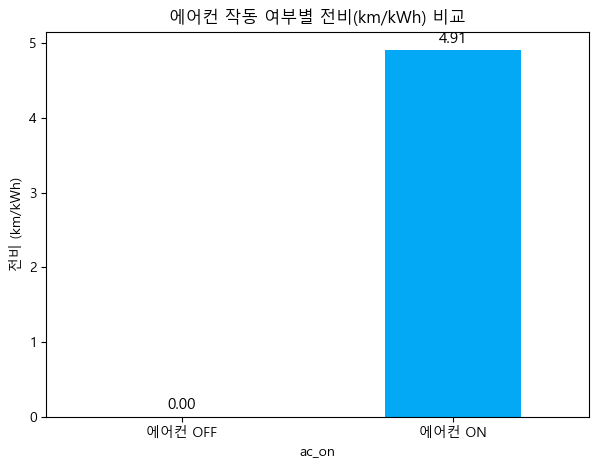

In [9]:


# 3️⃣ 에어컨 작동 여부
df_HC['ac_on'] = (df_HC['교류_컴프레서'] > 0).astype(int)

# 4️⃣ 전력 소비량 계산 (kW)
df_HC['power_kw'] = (df_HC['배터리_관리_시스템_고전압_팩_전류'] * df_HC['배터리_관리_시스템_고전압_팩_전압']) / 1000

# 5️⃣ 이동거리 계산 (km)
df_HC['dist_km'] = df_HC['클러스터_주행거리'].diff().clip(lower=0)

# 6️⃣ 에너지 사용량 (kWh)
df_HC['energy_kwh'] = df_HC['power_kw'] / 3600  # 샘플링 1초 가정

# 7️⃣ 그룹별 전비 계산
result = df_HC.groupby('ac_on').agg({
    'dist_km': 'sum',
    'energy_kwh': 'sum',
    '교류_내부_온도_전선': 'mean',
    '교류_외부_온도': 'mean'
})
result['전비(km/kWh)'] = result['dist_km'] / result['energy_kwh']
result = result.rename(index={0: '에어컨 OFF', 1: '에어컨 ON'})
print(result)

# 8️⃣ 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

result['전비(km/kWh)'].plot(
    kind='bar',
    color=['#4CAF50','#03A9F4'],
    title='에어컨 작동 여부별 전비(km/kWh) 비교',
    figsize=(7,5)
)
plt.ylabel('전비 (km/kWh)')
plt.xticks(rotation=0)

# 막대 위에 수치 표시
for i, v in enumerate(result['전비(km/kWh)']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=11)

plt.show()